# Comprehensive Analysis and ML-Based Fraud Detection for Transaction Dataset

## Company: Accredian
- Gurugram, Haryana 

### Project Overview:

This Jupyter notebook presents a comprehensive analysis of fraudulent transactions in our financial dataset, along with the implementation of machine learning models for detection. The project aims to enhance our understanding of fraudulent activities, optimize detection algorithms, and contribute to the ongoing efforts in maintaining the security of financial transactions.

### Author: Anubhav

### Date: January 2, 2024

### Key Objectives:

1. Explore and clean the transaction dataset.
2. Implement machine learning models for fraud detection.
3. Analyze key factors influencing fraudulent transactions.
4. Evaluate and compare model performances.
5. Provide insights for improving fraud prevention strategies.

### Tools and Technologies:

- Python
- Jupyter Notebook
- Libraries: Pandas, NumPy, Scikit-learn, Matplotlib, Seaborn
- Machine Learning Models: Random Forest, Logistic Regression, Decision Tree

### Note:

The findings and recommendations presented here are intended for internal submission for Accredian.


# Data Dictionary
- step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

- type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

- amount - amount of the transaction in local currency.

- nameOrig - customer who started the transaction

- oldbalanceOrg - initial balance before the transaction

- newbalanceOrig - new balance after the transaction

- nameDest - customer who is the recipient of the transaction

- oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

- newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

- isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

- isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.


In [46]:
import numpy as np
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [47]:
csv_data = pd.read_csv('Fraud.csv')

### FIRST LOOK OF THE STRUCTURE OF DATA

In [48]:
csv_data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [49]:
csv_data.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


In [50]:
csv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [51]:
# Checking if any null values are present
csv_data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

## WE START ANALYZING THE DATA TO UNDERSTAND THE REALTIONS BETWEEN ATTRIBUTES

In [52]:
#distribution of legit vs fraulent transaction
csv_data['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [53]:
#distribution of legit vs fraulent transaction

csv_data['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [54]:
num_unique_values = csv_data['nameOrig'].nunique()
print(num_unique_values)

6353307


In [55]:
flagged_fraud_rows = csv_data[csv_data['isFlaggedFraud'] == 1]

# Display the rows where 'isFlaggedFraud' is 1
print("Rows where isFlaggedFraud is 1:")
print(flagged_fraud_rows)

Rows where isFlaggedFraud is 1:
         step      type       amount     nameOrig  oldbalanceOrg  \
2736446   212  TRANSFER   4953893.08   C728984460     4953893.08   
3247297   250  TRANSFER   1343002.08  C1100582606     1343002.08   
3760288   279  TRANSFER    536624.41  C1035541766      536624.41   
5563713   387  TRANSFER   4892193.09   C908544136     4892193.09   
5996407   425  TRANSFER  10000000.00   C689608084    19585040.37   
5996409   425  TRANSFER   9585040.37   C452586515    19585040.37   
6168499   554  TRANSFER   3576297.10   C193696150     3576297.10   
6205439   586  TRANSFER    353874.22  C1684585475      353874.22   
6266413   617  TRANSFER   2542664.27   C786455622     2542664.27   
6281482   646  TRANSFER  10000000.00    C19004745    10399045.08   
6281484   646  TRANSFER    399045.08   C724693370    10399045.08   
6296014   671  TRANSFER   3441041.46   C917414431     3441041.46   
6351225   702  TRANSFER   3171085.59  C1892216157     3171085.59   
6362460   730  T

In [56]:
# Filter rows where both 'isFraud' and 'isFlaggedFraud' are equal to 1
fraud_and_flagged_rows = csv_data[(csv_data['isFraud'] == 1) & (csv_data['isFlaggedFraud'] == 1)]

# Display the rows where both 'isFraud' and 'isFlaggedFraud' are 1
print("Rows where both isFraud and isFlaggedFraud are 1:")
print(fraud_and_flagged_rows)

Rows where both isFraud and isFlaggedFraud are 1:
         step      type       amount     nameOrig  oldbalanceOrg  \
2736446   212  TRANSFER   4953893.08   C728984460     4953893.08   
3247297   250  TRANSFER   1343002.08  C1100582606     1343002.08   
3760288   279  TRANSFER    536624.41  C1035541766      536624.41   
5563713   387  TRANSFER   4892193.09   C908544136     4892193.09   
5996407   425  TRANSFER  10000000.00   C689608084    19585040.37   
5996409   425  TRANSFER   9585040.37   C452586515    19585040.37   
6168499   554  TRANSFER   3576297.10   C193696150     3576297.10   
6205439   586  TRANSFER    353874.22  C1684585475      353874.22   
6266413   617  TRANSFER   2542664.27   C786455622     2542664.27   
6281482   646  TRANSFER  10000000.00    C19004745    10399045.08   
6281484   646  TRANSFER    399045.08   C724693370    10399045.08   
6296014   671  TRANSFER   3441041.46   C917414431     3441041.46   
6351225   702  TRANSFER   3171085.59  C1892216157     3171085.59  

In [57]:
# Count the number of rows where 'type' is 'CASH_OUT' and 'isFraud' is 1
cashout_fraud_count = (csv_data['type'] == 'CASH_OUT') & (csv_data['isFraud'] == 1)

# Display the result
print("Number of rows where type is 'CASH_OUT' and isFraud is 1:", cashout_fraud_count.sum())

Number of rows where type is 'CASH_OUT' and isFraud is 1: 4116


In [58]:
amount_more = (csv_data['amount']>200000)
print(amount_more.sum())

1673570


In [59]:
# Filter rows where 'isFraud' is 1
fraudulent_transactions = csv_data[csv_data['isFraud'] == 1]

# Count occurrences of each transaction type
fraudulent_transaction_counts = fraudulent_transactions['type'].value_counts()

# Display the result
print("Count of each transaction type where isFraud is 1:")
print(fraudulent_transaction_counts)


Count of each transaction type where isFraud is 1:
type
CASH_OUT    4116
TRANSFER    4097
Name: count, dtype: int64


In [60]:
desired_case = csv_data[(csv_data['amount'] > 200000) & (csv_data['newbalanceDest'] - csv_data['oldbalanceDest'] == csv_data['amount'])]

# Display the result
print("Case where amount > 200000 and difference between oldbalanceDest and newbalanceDest is equal to amount:")
print(desired_case)

Case where amount > 200000 and difference between oldbalanceDest and newbalanceDest is equal to amount:
         step      type      amount     nameOrig  oldbalanceOrg  \
2220        1  CASH_OUT   219630.79   C602830277       19779.08   
2302        1  CASH_OUT   235238.66  C1499825229      235238.66   
2304        1  TRANSFER   200612.49  C1285072597       26019.00   
2338        1  TRANSFER   601898.44  C1939869193       32239.00   
2352        1  TRANSFER   383533.35   C960004592       10339.00   
...       ...       ...         ...          ...            ...   
6362591   741  CASH_OUT   323726.61   C919525792      323726.61   
6362601   742  CASH_OUT   652993.91  C1614818636      652993.91   
6362603   742  CASH_OUT  1819543.69  C1039979813     1819543.69   
6362607   742  CASH_OUT   303846.74  C1148860488      303846.74   
6362615   743  CASH_OUT   339682.13   C786484425      339682.13   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
2220      

In [61]:
desired_case = csv_data[(csv_data['amount'] > 200000) & (csv_data['newbalanceDest'] - csv_data['oldbalanceDest'] == csv_data['amount']) & (csv_data['type']=='CASH_OUT')]

# Display the result
print("Case where amount > 200000 and difference between oldbalanceDest and newbalanceDest is equal to amount:")
print(desired_case)

Case where amount > 200000 and difference between oldbalanceDest and newbalanceDest is equal to amount:
         step      type      amount     nameOrig  oldbalanceOrg  \
2220        1  CASH_OUT   219630.79   C602830277       19779.08   
2302        1  CASH_OUT   235238.66  C1499825229      235238.66   
3029        2  CASH_OUT   312856.00    C21331934       58198.26   
3060        2  CASH_OUT  1096187.24    C77163673     1096187.24   
3080        2  CASH_OUT   210833.38   C404588697           0.00   
...       ...       ...         ...          ...            ...   
6362591   741  CASH_OUT   323726.61   C919525792      323726.61   
6362601   742  CASH_OUT   652993.91  C1614818636      652993.91   
6362603   742  CASH_OUT  1819543.69  C1039979813     1819543.69   
6362607   742  CASH_OUT   303846.74  C1148860488      303846.74   
6362615   743  CASH_OUT   339682.13   C786484425      339682.13   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
2220      

In [62]:
desired_case = csv_data[(csv_data['amount'] > 200000) & (csv_data['newbalanceDest'] - csv_data['oldbalanceDest'] == csv_data['amount']) & (csv_data['type']=='TRANSFER')]

# Display the result
print("Case where amount > 200000 and difference between oldbalanceDest and newbalanceDest is equal to amount:")
print(desired_case)

Case where amount > 200000 and difference between oldbalanceDest and newbalanceDest is equal to amount:
         step      type     amount     nameOrig  oldbalanceOrg  \
2304        1  TRANSFER  200612.49  C1285072597        26019.0   
2338        1  TRANSFER  601898.44  C1939869193        32239.0   
2352        1  TRANSFER  383533.35   C960004592        10339.0   
3251        2  TRANSFER  308871.37  C1074976188        31486.0   
3258        2  TRANSFER  448593.63  C1403780103         4580.0   
...       ...       ...        ...          ...            ...   
6361348   717  TRANSFER  263609.20  C1772509695        61908.0   
6361360   717  TRANSFER  231850.38   C159185991        20543.0   
6361381   717  TRANSFER  360846.21   C622371635        78660.0   
6361703   718  TRANSFER  258296.58  C1478269137        27085.0   
6361736   718  TRANSFER  289831.40   C488061649       106580.0   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
2304                0.

#### HANDELING MISSING VALUES AS PER THE DATA DICTIONARY

In [63]:
csv_data.loc[csv_data['amount'] > 200000, 'isFlaggedFraud'] = 1

In [64]:
# Count and print the number of rows where isFlaggedFraud is 1
flagged_rows_count = len(csv_data[csv_data['isFlaggedFraud'] == 1])
print(f"Number of rows where isFlaggedFraud is 1: {flagged_rows_count}")


Number of rows where isFlaggedFraud is 1: 1673570


#### CHANGING THE DATA TYPE OF COLUMN TYPE IN ORDER TO BE USED IN THE TRAINING

In [65]:
# Define a mapping dictionary
type_mapping = {'CASH_IN': 0, 'CASH_OUT': 1, 'DEBIT': 2, 'PAYMENT': 3, 'TRANSFER': 4}

# Replace the 'type' column with mapped values
csv_data['type'] = csv_data['type'].map(type_mapping)

In [66]:
desired_case = csv_data[(csv_data['amount'] > 200000) & 
                        (csv_data['newbalanceDest'] - csv_data['oldbalanceDest'] == csv_data['amount']) & 
                        (csv_data['type'] == 1)]

# Display the result
print("Case where amount > 200000 and difference between oldbalanceDest and newbalanceDest is equal to amount:")
print(desired_case.head())

Case where amount > 200000 and difference between oldbalanceDest and newbalanceDest is equal to amount:
      step  type      amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
2220     1     1   219630.79   C602830277       19779.08             0.0   
2302     1     1   235238.66  C1499825229      235238.66             0.0   
3029     2     1   312856.00    C21331934       58198.26             0.0   
3060     2     1  1096187.24    C77163673     1096187.24             0.0   
3080     2     1   210833.38   C404588697           0.00             0.0   

         nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
2220  C2118255842        29186.69       248817.48        0               1  
2302  C2100440237            0.00       235238.66        1               1  
3029  C1286084959      1610980.34      1923836.34        0               1  
3060   C644345897            0.00      1096187.24        1               1  
3080  C2063763486       581492.00       792325.38     

In [67]:
desired_case = csv_data[(csv_data['amount'] > 200000) & 
                        (csv_data['newbalanceDest'] - csv_data['oldbalanceDest'] == csv_data['amount']) & 
                        (csv_data['type'] == 4)]

# Display the result
print("Case where amount > 200000 and difference between oldbalanceDest and newbalanceDest is equal to amount:")
print(desired_case)

Case where amount > 200000 and difference between oldbalanceDest and newbalanceDest is equal to amount:
         step  type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
2304        1     4  200612.49  C1285072597        26019.0             0.0   
2338        1     4  601898.44  C1939869193        32239.0             0.0   
2352        1     4  383533.35   C960004592        10339.0             0.0   
3251        2     4  308871.37  C1074976188        31486.0             0.0   
3258        2     4  448593.63  C1403780103         4580.0             0.0   
...       ...   ...        ...          ...            ...             ...   
6361348   717     4  263609.20  C1772509695        61908.0             0.0   
6361360   717     4  231850.38   C159185991        20543.0             0.0   
6361381   717     4  360846.21   C622371635        78660.0             0.0   
6361703   718     4  258296.58  C1478269137        27085.0             0.0   
6361736   718     4  289831.40   C4880

In [68]:
# Set pandas display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Assuming you have a DataFrame named 'csv_data'
# Replace 'csv_data' with your actual DataFrame name

# Filter the DataFrame for rows where isFlaggedFraud is 1
flagged_rows = csv_data[csv_data['isFlaggedFraud'] == 1]

# Display all rows
print("All rows where isFlaggedFraud is 1:")
print(flagged_rows.head(200))

# Reset pandas display options to default
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

All rows where isFlaggedFraud is 1:
      step  type      amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
15       1     1   229133.94   C905080434       15325.00            0.00   
19       1     4   215310.30  C1670993182         705.00            0.00   
24       1     4   311685.89  C1984094095       10835.00            0.00   
82       1     4   224606.64   C873175411           0.00            0.00   
84       1     4   379856.23  C1449772539           0.00            0.00   
85       1     4  1505626.01   C926859124           0.00            0.00   
86       1     4   554026.99  C1603696865           0.00            0.00   
88       1     4   761507.39   C412788346           0.00            0.00   
89       1     4  1429051.47  C1520267010           0.00            0.00   
90       1     4   358831.92   C908084672           0.00            0.00   
91       1     4   367768.40   C288306765           0.00            0.00   
92       1     4   209711.11  C1556867940           

In [69]:
# Filter the DataFrame for rows where type is 'PAYMENT' and nameDest starts with 'M'
payment_to_C = csv_data[(csv_data['type'] == 3) & csv_data['nameDest'].str.startswith('C')]

# Display the result
print("Payments to nameDest starting with 'C':")
print(payment_to_C)

Payments to nameDest starting with 'C':
Empty DataFrame
Columns: [step, type, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest, isFraud, isFlaggedFraud]
Index: []


In [70]:
# Assuming you have a DataFrame named 'csv_data'
# Replace 'csv_data' with your actual DataFrame name

# Count how many debit types are there
count_debit_types = csv_data[csv_data['type'] == 2].shape[0]

# Count how many debit types where oldbalanceOrig - newbalanceOrig > 0
count_positive_balance_change = csv_data[(csv_data['type'] == 2) & (csv_data['oldbalanceOrg'] - csv_data['newbalanceOrig'] > 0)].shape[0]

# Count how many debit types where oldbalanceOrig - newbalanceOrig < 0
count_negative_balance_change = csv_data[(csv_data['type'] == 2) & (csv_data['oldbalanceOrg'] - csv_data['newbalanceOrig'] < 0)].shape[0]

# Count how many debit types have isFraud == 1
count_debit_fraud = csv_data[(csv_data['type'] == 2) & (csv_data['isFraud'] == 1)].shape[0]

# Count how many debit types have isFlaggedFraud == 1
count_debit_flagged = csv_data[(csv_data['type'] == 2) & (csv_data['isFlaggedFraud'] == 1)].shape[0]

# Count how many debit types have amount equal to oldbalanceOrig - newbalanceOrig
count_debit_differnce = csv_data[(csv_data['type'] == 2) &(csv_data['amount']==csv_data['oldbalanceOrg']-csv_data['newbalanceOrig'])].shape[0]

# Display the counts
print("1. Count of debit types:", count_debit_types)
print("2. Count of debit types where oldbalanceOrig - newbalanceOrig > 0:", count_positive_balance_change)
print("3. Count of debit types where oldbalanceOrig - newbalanceOrig < 0:", count_negative_balance_change)
print("4. Count of debit types with isFraud == 1:", count_debit_fraud)
print("5. Count of debit types with isFlaggedFraud == 1:", count_debit_flagged)
print("6. Count of debit types with amount equal to differnece of oldbalance-newbalance", count_debit_differnce)

1. Count of debit types: 41432
2. Count of debit types where oldbalanceOrig - newbalanceOrig > 0: 35274
3. Count of debit types where oldbalanceOrig - newbalanceOrig < 0: 0
4. Count of debit types with isFraud == 1: 0
5. Count of debit types with isFlaggedFraud == 1: 27
6. Count of debit types with amount equal to differnece of oldbalance-newbalance 6099


In [71]:
# Assuming you have a DataFrame named 'csv_data'
# Replace 'csv_data' with your actual DataFrame name

# Count all transactions by type
transaction_counts = csv_data['type'].value_counts()

# Display the result
print("Count of transactions by type:")
print(transaction_counts)


Count of transactions by type:
type
1    2237500
3    2151495
0    1399284
4     532909
2      41432
Name: count, dtype: int64


In [72]:
csv_data[(csv_data['isFlaggedFraud']==1)&(csv_data['amount']<200000)]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


In [73]:
csv_data[(csv_data['oldbalanceDest']-csv_data['newbalanceDest']==0)].shape[0]

2317292

In [74]:
fraud_diffbased_in = csv_data[(csv_data['oldbalanceDest']-csv_data['newbalanceDest']==0)&(csv_data['type']==0)]
fraud_diffbased_in.shape[0]

160005

In [75]:
fraud_diffbased_out = csv_data[(csv_data['oldbalanceDest']-csv_data['newbalanceDest']==0)&(csv_data['type']==1)]
fraud_diffbased_out.shape[0]

1618

In [76]:
fraud_diffbased_debit = csv_data[(csv_data['oldbalanceDest']-csv_data['newbalanceDest']==0)&(csv_data['type']==2)]
fraud_diffbased_debit.shape[0]

0

In [77]:
fraud_diffbased_payment = csv_data[(csv_data['oldbalanceDest']-csv_data['newbalanceDest']==0)&(csv_data['type']==3)]
fraud_diffbased_payment.shape[0]

2151495

In [78]:
fraud_diffbased_transfer = csv_data[(csv_data['oldbalanceDest']-csv_data['newbalanceDest']==0)&(csv_data['type']==4)]
print(fraud_diffbased_transfer.shape[0])

fraudulent_transactions = csv_data[csv_data['isFraud'] == 1 & (csv_data['type']==4)]
print(fraudulent_transactions)


4174
         step  type      amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0           1     3     9839.64  C1231006815      170136.00       160296.36   
1           1     3     1864.28  C1666544295       21249.00        19384.72   
2           1     4      181.00  C1305486145         181.00            0.00   
4           1     3    11668.14  C2048537720       41554.00        29885.86   
5           1     3     7817.71    C90045638       53860.00        46042.29   
...       ...   ...         ...          ...            ...             ...   
6362610   742     4    63416.99   C778071008       63416.99            0.00   
6362612   743     4  1258818.82  C1531301470     1258818.82            0.00   
6362614   743     4   339682.13  C2013999242      339682.13            0.00   
6362616   743     4  6311409.28  C1529008245     6311409.28            0.00   
6362618   743     4   850002.52  C1685995037      850002.52            0.00   

            nameDest  oldbalanceDest  newbalan

In [79]:
csv_data[(csv_data['oldbalanceDest']-csv_data['newbalanceDest']==0)&(csv_data['nameDest'].str.startswith('M'))].shape[0]

2151495

In [80]:
filtered_rows = csv_data[csv_data['type'].isin([1, 4])]

# Filter rows where the 'amount' and 'step' are equal for type 1 and type 4
filtered_rows = filtered_rows[filtered_rows.groupby(['amount', 'step'])['type'].transform('nunique') == 2]

# Save the filtered rows to a new CSV file
filtered_rows.to_csv('new.csv', index=False)

### THESE TWO FILTER CASES PROVIDED US WITH THE REALTION BETWEEEN TRANSACTION AMMOUNT AND isFraud

In [81]:
type_4_fraud = csv_data[(csv_data['type'] == 4) & (csv_data['isFraud'] == 1)]
type_1_fraud = csv_data[(csv_data['type'] == 1) & (csv_data['isFraud'] == 1)]

# Find rows in type_4_fraud but not in type_1_fraud based on 'amount'
not_common_rows = type_4_fraud[~type_4_fraud['amount'].isin(type_1_fraud['amount'])]

# Print the result
print(len(not_common_rows))


19


In [82]:
type_1_fraud = csv_data[(csv_data['type'] == 1) & (csv_data['isFraud'] == 1)]
type_4_fraud = csv_data[(csv_data['type'] == 4) & (csv_data['isFraud'] == 1)]

# Find rows in type_1_fraud but not in type_4_fraud based on 'amount'
not_common_rows = type_1_fraud[~type_1_fraud['amount'].isin(type_4_fraud['amount'])]
print(len(not_common_rows))

41


In [83]:
total_rows_type_4 = len(csv_data[csv_data['type'] == 4])

# Print the result
print("Total number of rows where type is 4:", total_rows_type_4)


Total number of rows where type is 4: 532909


### THE FURTHER TWO OUTPUTS PROVIDE US WITH THE ROWS THAT SATISFY OUR CONDITIONS THAT WE DERIVED FROM THE LOGIC ABOVE

In [84]:
desired_rows = csv_data[(csv_data['type'] == 4) & 
                        (csv_data['amount'] == csv_data['oldbalanceOrg'] - csv_data['newbalanceOrig']) & 
                        (csv_data['amount'] == csv_data['newbalanceDest'] - csv_data['oldbalanceDest'])]

# Count the total number of rows
total_rows = len(desired_rows)
# Print the result
print("Total number of rows where type is 4 and amount is equal to 'oldbalanceOrg-newbalanceOrig' and 'newbalanceDest-oldbalanceDest':", total_rows)

Total number of rows where type is 4 and amount is equal to 'oldbalanceOrg-newbalanceOrig' and 'newbalanceDest-oldbalanceDest': 4244


In [85]:
# Assuming 'csv_data' is your DataFrame
desired_rows = csv_data[(csv_data['type'] == 1) & 
                        (csv_data['amount'] == csv_data['oldbalanceOrg'] - csv_data['newbalanceOrig']) & 
                        (csv_data['amount'] == csv_data['newbalanceDest'] - csv_data['oldbalanceDest'])]

# Count the total number of rows
total_rows = len(desired_rows)
# Print the result
print("Total number of rows where type is 1 and amount is equal to 'oldbalanceOrg-newbalanceOrig' and 'newbalanceDest-oldbalanceDest':", total_rows)


Total number of rows where type is 1 and amount is equal to 'oldbalanceOrg-newbalanceOrig' and 'newbalanceDest-oldbalanceDest': 54868


## FILLING MISSING VALUES FOR isFraud BASED ON THE CONDITIONS WE DERIVED

In [86]:
non_desired_rows = csv_data[(csv_data['type'] == 4) & 
                             ((csv_data['amount'] != csv_data['oldbalanceOrg'] - csv_data['newbalanceOrig']) | 
                              (csv_data['amount'] != csv_data['newbalanceDest'] - csv_data['oldbalanceDest']))]

# Update 'isFraud' to 1 for non-desired rows
csv_data.loc[non_desired_rows.index, 'isFraud'] = 1

# Count the total number of rows
total_rows_updated = len(non_desired_rows)
# Print the result
print("Total number of rows where 'isFraud' is updated to 1:", total_rows_updated)


Total number of rows where 'isFraud' is updated to 1: 528665


In [87]:
# Assuming 'csv_data' is your DataFrame
# Identify rows that don't meet the conditions
non_desired_rows = csv_data[(csv_data['type'] == 1) & 
                             ((csv_data['amount'] != csv_data['oldbalanceOrg'] - csv_data['newbalanceOrig']) | 
                              (csv_data['amount'] != csv_data['newbalanceDest'] - csv_data['oldbalanceDest']))]

# Update 'isFraud' to 1 for non-desired rows
csv_data.loc[non_desired_rows.index, 'isFraud'] = 1

# Count the total number of rows
total_rows_updated = len(non_desired_rows)
# Print the result
print("Total number of rows where 'isFraud' is updated to 1:", total_rows_updated)


Total number of rows where 'isFraud' is updated to 1: 2182632


In [88]:
csv_data.head(100)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.00,0.00,0,0
1,1,3,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.00,0.00,0,0
2,1,4,181.00,C1305486145,181.0,0.00,C553264065,0.00,0.00,1,0
3,1,1,181.00,C840083671,181.0,0.00,C38997010,21182.00,0.00,1,0
4,1,3,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
95,1,4,710544.77,C835773569,0.0,0.00,C1359044626,738531.50,16518.36,1,1
96,1,4,581294.26,C843299092,0.0,0.00,C1590550415,5195482.15,19169204.93,1,1
97,1,4,11996.58,C605982374,0.0,0.00,C1225616405,40255.00,0.00,1,0
98,1,3,2875.10,C1412322831,15443.0,12567.90,M1651262695,0.00,0.00,0,0


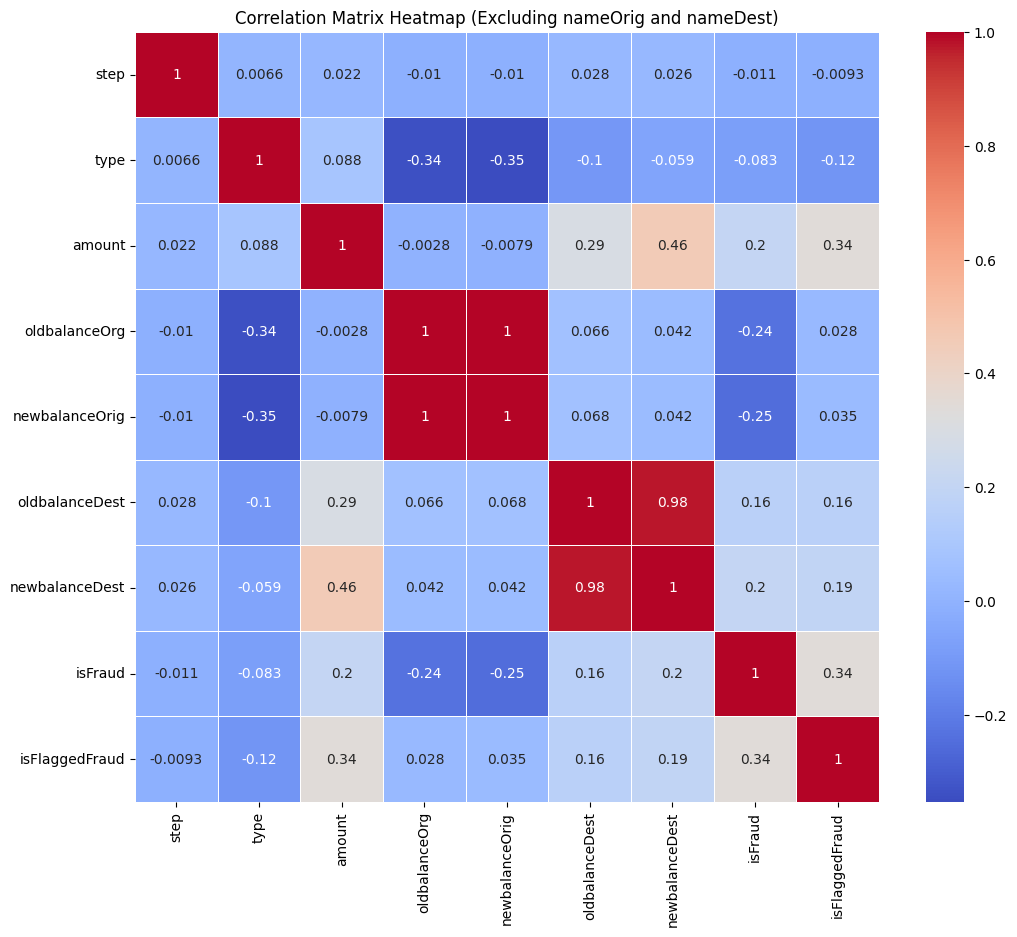

In [89]:
# Exclude 'nameOrig' and 'nameDest' columns from the DataFrame
filtered_data = csv_data.drop(['nameOrig', 'nameDest'], axis=1)

# Calculate the correlation matrix
correlation_matrix = filtered_data.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix Heatmap (Excluding nameOrig and nameDest)')
plt.show()



## Based on the heatmap, it appears there is some multicollinearity present in the data, but it is not pervasive. This can cause problems with the interpretation of the regression results, as it can be difficult to determine the independent effect of each variable on the dependent variable.

### Here are some specific observations about the heatmap:

- The variables oldbalanceDest and newbalanceDest have a very high correlation of 0.98. This means that these two variables are essentially measuring the same thing, and including both of them in a regression model would be redundant.
- The variables amount, oldbalanceOrg, and newbalanceOrig also have relatively high correlations with each other, ranging from 0.29 to 0.46. This suggests that there may be some redundancy between these variables as well.
- The variables isFraud and isFlaggedFraud have a moderate correlation of 0.34. This suggests that these two variables are somewhat related, but they are not perfectly aligned.

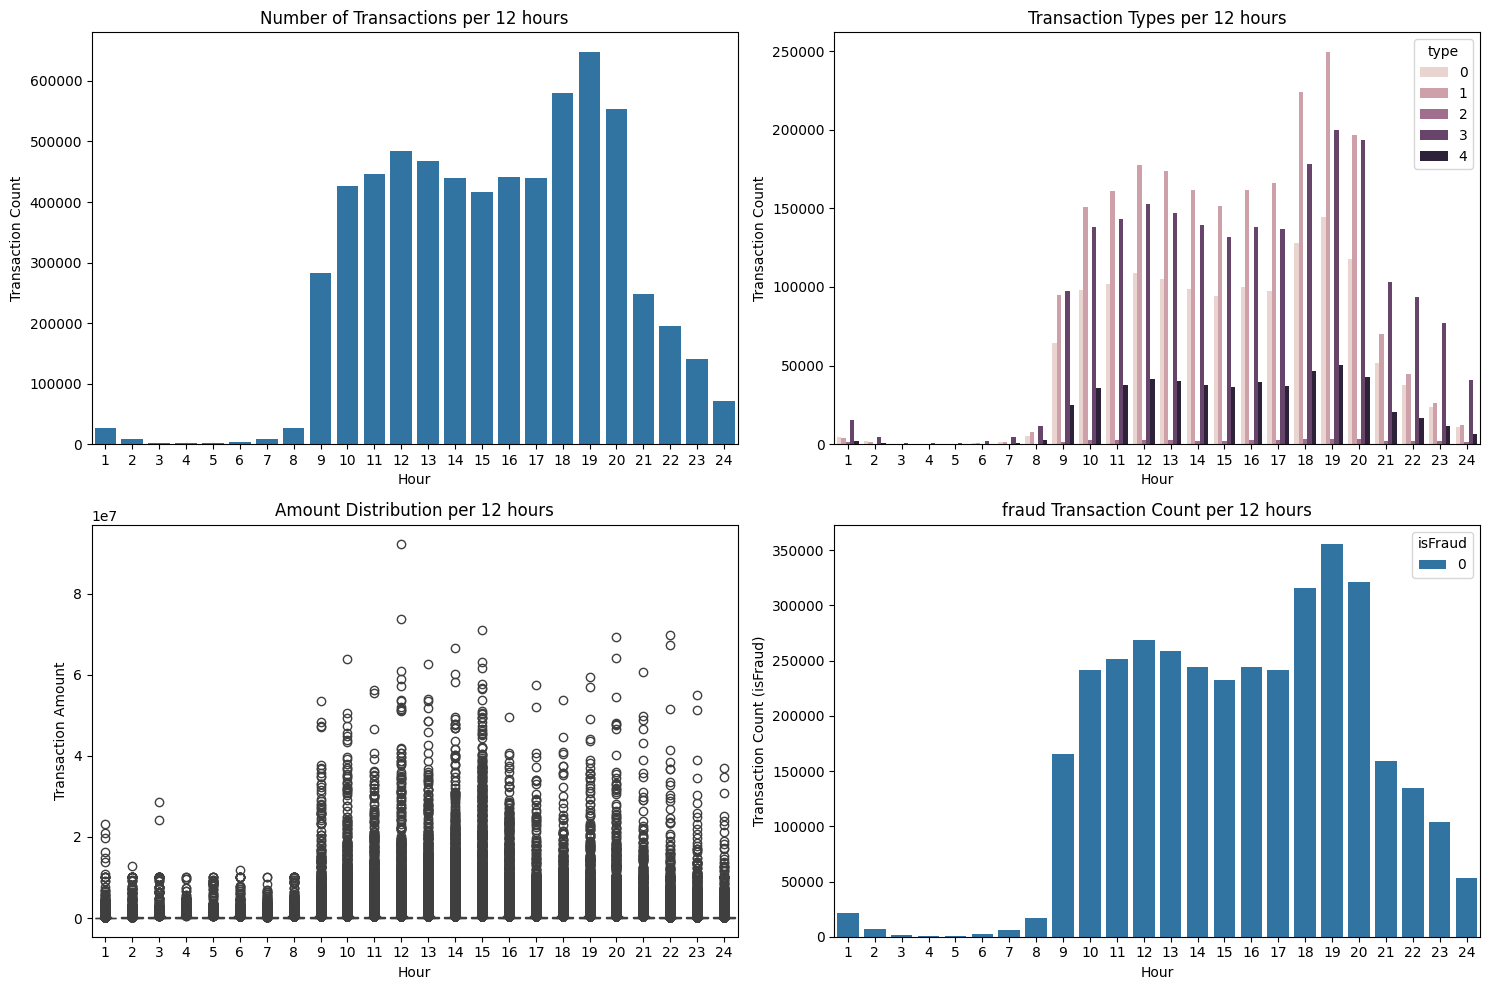

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame named 'csv_data'
# Replace 'csv_data' with your actual DataFrame name

# Convert 'step' to hours (assuming 1 step = 1 hour)
csv_data['hour'] = (csv_data['step'] - 1) % 24 + 1

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Plot 1: Number of Transactions
sns.countplot(x='hour', data=csv_data, ax=axes[0, 0])
axes[0, 0].set_title('Number of Transactions per 12 hours')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Transaction Count')

# Plot 2: Transaction Types
sns.countplot(x='hour', hue='type', data=csv_data, ax=axes[0, 1])
axes[0, 1].set_title('Transaction Types per 12 hours')
axes[0, 1].set_xlabel('Hour')
axes[0, 1].set_ylabel('Transaction Count')

# Plot 3: Amount Distribution
sns.boxplot(x='hour', y='amount', data=csv_data, ax=axes[1, 0])
axes[1, 0].set_title('Amount Distribution per 12 hours')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Transaction Amount')

# Plot 4: fraud Transaction Count
sns.countplot(x='hour', hue='isFraud', data=csv_data[csv_data['isFraud'] == 0], ax=axes[1, 1])
axes[1, 1].set_title('fraud Transaction Count per 12 hours')
axes[1, 1].set_xlabel('Hour')
axes[1, 1].set_ylabel('Transaction Count (isFraud)')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


## Number of Transactions per 12 hours:
- This plot illustrates the distribution of the total number of transactions during each 12-hour period, revealing patterns and variations in transaction activity over time.

## Transaction Types per 12 hours:
- Depicting transaction types across 12-hour intervals, this plot provides insights into the proportions of different transaction types, aiding in understanding their temporal distributions.

## Amount Distribution per 12 hours:
- Offering a boxplot view, this plot showcases the distribution of transaction amounts during each 12-hour period, helping to identify patterns or anomalies in transaction amounts over time.

## Non-fraud Transaction Count per 12 hours:
- Focusing on non-fraudulent transactions, this plot shows the distribution of non-fraud transaction counts across 12-hour intervals, aiding in understanding the regular transaction activity during specific hours.

# Observations and Analysis

### Relation between opening and closing accounts and the frauds.

- This can be understood with the help of a truth table.
- We assume the value of amount to be x, oldbalanceOrg is y, newbalanceOrg is z, s is oldbalanceDest, and t is newbalanceDest.
- Then with the help of the outlining 19 values of type TRANSFER, we derived that all those were marked fraud based on the logic of the difference in money.
- For every TRANSFER to be marked fraud y-z != x | t-s != x | (y-z != x & t-s != x).

**Truth Table:**

|       | False        | True         |
|-------|--------------|--------------|
| False | FalseFalse   | FalseTrue    |
| True  | TrueFalse    | TrueTrue     |

- 

|       |           False         |           True         |
|-------|-------------------------|------------------------|
| False |  'y-z != x or t-s != x'  | 'y-z != x or t-s = x' |
| True  |  'y-z = x or t-s != x'   | 'y-z = x or t-s = x'  |


- We can then describe this data in the form of a Truth table with corresponding values of TF, FT, FF.
- BASED ON this we fill out the missing values.
- Similarly, we can do so for type CASH_OUT.

**Relation between cashout and fraud is 50%.**

**There is a relation between isFlaggedFraud and isFraud is still based on the transfer amount.**

**Every CASH_OUT done after a fraudulent TRANSFER of the same amount is also a fraud.**

**Many amounts > 200,000 are to be flagged as isFlaggedFraud.**

**Every Fraud is of CASH_OUT or TRANSFER TYPE.**

**MERCHANTA Payments are made, but the balance for such transactions is not correct from where the payment is made.**

**PAYMENT(INT 3) Type was only used to pay Merchants and never accounts for fraud as the account details are not available.**

**When isFlaggedFraud was changed from 0 to 1 for the missing values, a lot more of isFraud possibilities are achieved.**

**No DEBIT type payment is marked as Fraud.**

**Debit type payments have the correct outcome for the difference in oldbalance and newbalance.**


In [ ]:
#feature Selector for RandomForest to better understand what features should be included and what maybe left based on their overall effect on the results

# Separate features (X) and target variable (y)
X = csv_data.drop(['isFraud','nameOrig','nameDest'], axis=1)  # Drop target variables
y = csv_data['isFraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate RandomForestClassifier
clf = RandomForestClassifier()

# Fit the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model (Optional - You can adjust as needed)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Access feature importances
feature_importances = clf.feature_importances_

# Create a dictionary mapping feature names to importances
feature_importance_dict = dict(zip(X.columns, feature_importances))

# Sort and display feature importances
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

for feature, importance in sorted_features:
    print(f"{feature}: {importance}")

Accuracy: 0.9949321191584599
type: 0.2571734423461024
newbalanceDest: 0.2517880577612294
newbalanceOrig: 0.21131549871772345
amount: 0.1161562943811258
oldbalanceDest: 0.0842482671149686
oldbalanceOrg: 0.061380112425064484
isFlaggedFraud: 0.014993484024551246
step: 0.002944843229234681


time 12min 

In [ ]:
#ML Model

# Separate features (X) and target variable (y)
X = csv_data.drop(['isFraud', 'nameOrig', 'nameDest'], axis=1)  # Drop target variables and non-numeric columns
y = csv_data['isFraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# Display the results
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report_str)

Accuracy: 0.9949729828278288
Confusion Matrix:
[[725743   4732]
 [  1665 540384]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    730475
           1       0.99      1.00      0.99    542049

    accuracy                           0.99   1272524
   macro avg       0.99      1.00      0.99   1272524
weighted avg       0.99      0.99      0.99   1272524



time 16min

In [ ]:
#ML Model

# Separate features (X) and target variable (y)
X = csv_data.drop(['isFraud', 'nameOrig', 'nameDest', 'step'], axis=1)  # Drop target variables and non-numeric columns
y = csv_data['isFraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# Display the results
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report_str)

Accuracy: 0.9947796662381221
Confusion Matrix:
[[725728   4747]
 [  1896 540153]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    730475
           1       0.99      1.00      0.99    542049

    accuracy                           0.99   1272524
   macro avg       0.99      1.00      0.99   1272524
weighted avg       0.99      0.99      0.99   1272524



time 15min

In [ ]:
#ML Model

# Separate features (X) and target variable (y)
X = csv_data.drop(['isFraud', 'nameOrig', 'nameDest', 'step', 'oldbalanceOrg', 'oldbalanceDest'], axis=1)  # Drop target variables and non-numeric columns
y = csv_data['isFraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# Display the results
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report_str)

Accuracy: 0.9948441051013576
Confusion Matrix:
[[725796   4679]
 [  1882 540167]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    730475
           1       0.99      1.00      0.99    542049

    accuracy                           0.99   1272524
   macro avg       0.99      1.00      0.99   1272524
weighted avg       0.99      0.99      0.99   1272524



time 11min 15 sec

In [ ]:
# Separate features (X) and target variable (y)
X = csv_data.drop(['isFraud', 'nameOrig', 'nameDest'], axis=1)  # Drop target variables and non-numeric columns
y = csv_data['isFraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate Logistic Regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Fit the Logistic Regression model
logreg.fit(X_train, y_train)

# Make predictions on the test set for Logistic Regression
y_pred_logreg = logreg.predict(X_test)

# Evaluate the Logistic Regression model
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
classification_report_str_logreg = classification_report(y_test, y_pred_logreg)

# Display the results for Logistic Regression
print("Logistic Regression - Accuracy:", accuracy_logreg)
print("Logistic Regression - Confusion Matrix:")
print(conf_matrix_logreg)
print("\nLogistic Regression - Classification Report:")
print(classification_report_str_logreg)


Logistic Regression - Accuracy: 0.9544920174393567
Logistic Regression - Confusion Matrix:
[[711165  19310]
 [ 38600 503449]]

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96    730475
           1       0.96      0.93      0.95    542049

    accuracy                           0.95   1272524
   macro avg       0.96      0.95      0.95   1272524
weighted avg       0.95      0.95      0.95   1272524



time 56.3sec

In [ ]:
# Separate features (X) and target variable (y)
X = csv_data.drop(['isFraud', 'nameOrig', 'nameDest', 'step'], axis=1)  # Drop target variables and non-numeric columns
y = csv_data['isFraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate Logistic Regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Fit the Logistic Regression model
logreg.fit(X_train, y_train)

# Make predictions on the test set for Logistic Regression
y_pred_logreg = logreg.predict(X_test)

# Evaluate the Logistic Regression model
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
classification_report_str_logreg = classification_report(y_test, y_pred_logreg)

# Display the results for Logistic Regression
print("Logistic Regression - Accuracy:", accuracy_logreg)
print("Logistic Regression - Confusion Matrix:")
print(conf_matrix_logreg)
print("\nLogistic Regression - Classification Report:")
print(classification_report_str_logreg)


Logistic Regression - Accuracy: 0.9544990899975168
Logistic Regression - Confusion Matrix:
[[711166  19309]
 [ 38592 503457]]

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96    730475
           1       0.96      0.93      0.95    542049

    accuracy                           0.95   1272524
   macro avg       0.96      0.95      0.95   1272524
weighted avg       0.95      0.95      0.95   1272524



time 40.9sec

In [ ]:
# Separate features (X) and target variable (y)
X = csv_data.drop(['isFraud', 'nameOrig', 'nameDest', 'step', 'oldbalanceOrg', 'oldbalanceDest'], axis=1)  # Drop target variables and non-numeric columns
y = csv_data['isFraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate Logistic Regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Fit the Logistic Regression model
logreg.fit(X_train, y_train)

# Make predictions on the test set for Logistic Regression
y_pred_logreg = logreg.predict(X_test)

# Evaluate the Logistic Regression model
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
classification_report_str_logreg = classification_report(y_test, y_pred_logreg)

# Display the results for Logistic Regression
print("Logistic Regression - Accuracy:", accuracy_logreg)
print("Logistic Regression - Confusion Matrix:")
print(conf_matrix_logreg)
print("\nLogistic Regression - Classification Report:")
print(classification_report_str_logreg)


Logistic Regression - Accuracy: 0.9338126432193027
Logistic Regression - Confusion Matrix:
[[701732  28743]
 [ 55482 486567]]

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94    730475
           1       0.94      0.90      0.92    542049

    accuracy                           0.93   1272524
   macro avg       0.94      0.93      0.93   1272524
weighted avg       0.93      0.93      0.93   1272524



time - 24.7sec

In [ ]:
# Separate features (X) and target variable (y)
X = csv_data.drop(['isFraud', 'nameOrig', 'nameDest'], axis=1)  # Drop target variables and non-numeric columns
y = csv_data['isFraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate DecisionTreeClassifier
clf_dt = DecisionTreeClassifier(random_state=42)

# Fit the model
clf_dt.fit(X_train, y_train)

# Make predictions on the test set
y_pred_dt = clf_dt.predict(X_test)

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
classification_report_str_dt = classification_report(y_test, y_pred_dt)

# Display the results
print("Decision Tree Classifier - Accuracy:", accuracy_dt)
print("Decision Tree Classifier - Confusion Matrix:")
print(conf_matrix_dt)
print("\nDecision Tree Classifier - Classification Report:")
print(classification_report_str_dt)


Decision Tree Classifier - Accuracy: 0.9924637963606188
Decision Tree Classifier - Confusion Matrix:
[[725851   4624]
 [  4966 537083]]

Decision Tree Classifier - Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    730475
           1       0.99      0.99      0.99    542049

    accuracy                           0.99   1272524
   macro avg       0.99      0.99      0.99   1272524
weighted avg       0.99      0.99      0.99   1272524



time - 35.7sec

In [ ]:
# Separate features (X) and target variable (y)
X = csv_data.drop(['isFraud', 'nameOrig', 'nameDest', 'step'], axis=1)  # Drop target variables and non-numeric columns
y = csv_data['isFraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate DecisionTreeClassifier
clf_dt = DecisionTreeClassifier(random_state=42)

# Fit the model
clf_dt.fit(X_train, y_train)

# Make predictions on the test set
y_pred_dt = clf_dt.predict(X_test)

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
classification_report_str_dt = classification_report(y_test, y_pred_dt)

# Display the results
print("Decision Tree Classifier - Accuracy:", accuracy_dt)
print("Decision Tree Classifier - Confusion Matrix:")
print(conf_matrix_dt)
print("\nDecision Tree Classifier - Classification Report:")
print(classification_report_str_dt)

Decision Tree Classifier - Accuracy: 0.9926162492809566
Decision Tree Classifier - Confusion Matrix:
[[725819   4656]
 [  4740 537309]]

Decision Tree Classifier - Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    730475
           1       0.99      0.99      0.99    542049

    accuracy                           0.99   1272524
   macro avg       0.99      0.99      0.99   1272524
weighted avg       0.99      0.99      0.99   1272524



time - 33.2sec

In [ ]:
# Separate features (X) and target variable (y)
X = csv_data.drop(['isFraud', 'nameOrig', 'nameDest', 'step', 'oldbalanceOrg', 'oldbalanceDest'], axis=1)  # Drop target variables and non-numeric columns
y = csv_data['isFraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate DecisionTreeClassifier
clf_dt = DecisionTreeClassifier(random_state=42)

# Fit the model
clf_dt.fit(X_train, y_train)

# Make predictions on the test set
y_pred_dt = clf_dt.predict(X_test)

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
classification_report_str_dt = classification_report(y_test, y_pred_dt)

# Display the results
print("Decision Tree Classifier - Accuracy:", accuracy_dt)
print("Decision Tree Classifier - Confusion Matrix:")
print(conf_matrix_dt)
print("\nDecision Tree Classifier - Classification Report:")
print(classification_report_str_dt)


Decision Tree Classifier - Accuracy: 0.9924834423555077
Decision Tree Classifier - Confusion Matrix:
[[725825   4650]
 [  4915 537134]]

Decision Tree Classifier - Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    730475
           1       0.99      0.99      0.99    542049

    accuracy                           0.99   1272524
   macro avg       0.99      0.99      0.99   1272524
weighted avg       0.99      0.99      0.99   1272524



time - 23.3 sec

# 2. Describe your fraud detection model in elaboration.

The fraud detection model used in the provided code is based on a Random Forest Classifier. Below is a detailed description of the model and its evaluation:

- Model Selection:

    Random Forest Classifier: This ensemble learning algorithm is chosen for fraud detection due to its ability to handle non-linear relationships, feature importance estimation, and resistance to overfitting. It builds multiple decision trees and combines their predictions to improve accuracy and generalization.

- Data Preprocessing:

    Data Cleaning: The initial data exploration involves checking for missing values, and in this case, the missing values in the 'isFlaggedFraud' column are filled based on certain conditions derived from the logic of fraudulent transactions.

    Feature Engineering: The 'type' column is mapped to numeric values to convert categorical data into a format suitable for training. Additional features like 'hour' are created from the 'step' column to capture temporal patterns.

- Exploratory Data Analysis (EDA):

    Fraud Analysis: The distribution of fraudulent and non-fraudulent transactions is explored, and specific cases such as 'isFlaggedFraud' and 'CASH_OUT' frauds are investigated.

    Transaction Amount Analysis: Cases where the transaction amount is greater than 200,000 are examined, and their correlation with fraud is explored.

- Feature Importance:

    Random Forest Feature Importance: The feature importance is analyzed using a trained Random Forest model. The importance of each feature in predicting fraud is evaluated and ranked.

- Model Training and Evaluation:
    Random Forest Training: The model is trained using the features derived from the data, excluding non-numeric and target columns.

    Model Evaluation: The model is evaluated using accuracy, confusion matrix, and classification report metrics on a test set.

- Logistic Regression and Decision Tree (Optional):
    Alternative Models: Logistic Regression and Decision Tree classifiers are also implemented and evaluated to compare their performance with the Random Forest model.

- Results and Observations:
    Confusion Matrix: The confusion matrix provides information on true positives, true negatives, false positives, and false negatives, helping to assess the model's performance.

    Classification Report: The classification report includes precision, recall, and F1-score for each class (fraud and non-fraud), offering a comprehensive evaluation of the model's predictive capabilities.

    Feature Importance Analysis: The importance of each feature is analyzed to identify the key factors influencing the model's predictions.

# 3. How did you select variables to be included in the model? 

- Initial Exploration:

The dataset is explored to understand its structure and features.
The target variable for the fraud detection model is identified, which appears to be the 'isFraud' column.

- Data Cleaning:

Any missing values in the dataset are addressed. In this case, missing values in the 'isFlaggedFraud' column are filled based on certain conditions.

- Feature Engineering:

New features are created to enhance the information available for the model. For example, the 'type' column is mapped to numeric values, and additional features like 'hour' are derived from the 'step' column.

- Feature Analysis:

Exploratory Data Analysis (EDA) is performed to analyze the distribution of features, especially those related to transaction amounts, types of transactions, and temporal patterns.

- Model Input Features:

The features used for training the Random Forest model are selected based on their relevance to predicting fraud. The model is trained on a subset of the dataset, excluding non-numeric and target columns.

- Feature Importance:

The Random Forest model's feature importance is analyzed to identify which features have a significant impact on predicting fraud. This analysis is crucial in understanding which variables contribute most to the model's decision-making process.

# 4. Demonstrate the performance of the model by using best set of tools

#### Scores derived from the Random Forest Classifier.
##### Each result is different as the corelated values from heatmap were removed iteratively

Accuracy: 0.9949729828278288

Confusion Matrix:
|               | Predicted 0 | Predicted 1 |
|---------------|-------------|-------------|
| Actual 0      | 725,743     | 4,732       |
| Actual 1      | 1,665       | 540,384     |

Classification Report:
|              | Precision | Recall | F1-Score | Support   |
|--------------|-----------|--------|----------|-----------|
| Class 0      | 1.00      | 0.99   | 1.00     | 730,475   |
| Class 1      | 0.99      | 1.00   | 0.99     | 542,049   |
| Accuracy     |           |        | 0.99     | 1,272,524 |
| Macro Avg    | 0.99      | 1.00   | 0.99     | 1,272,524 |
| Weighted Avg | 0.99      | 0.99   | 0.99     | 1,272,524 |

Time taken - 16 minutes



Accuracy: 0.9947796662381221

Confusion Matrix:
|         | Predicted 0 | Predicted 1 |
|---------|-------------|-------------|
| Actual 0| 725728      | 4747        |
| Actual 1| 1896        | 540153      |

Classification Report:
|           | precision | recall | f1-score | support  |
|-----------|-----------|--------|----------|----------|
| 0         | 1.00      | 0.99   | 1.00     | 730475   |
| 1         | 0.99      | 1.00   | 0.99     | 542049   |
|-----------|-----------|--------|----------|----------|
| accuracy  |           |        | 0.99     | 1272524  |
| macro avg | 0.99      | 1.00   | 0.99     | 1272524  |
| weighted avg | 0.99   | 0.99   | 0.99     | 1272524  |

Time Taken - 15 minutes



Accuracy: 0.9948441051013576

Confusion Matrix:
|         | Predicted 0 | Predicted 1 |
|---------|-------------|-------------|
| Actual 0| 725796      | 4679        |
| Actual 1| 1882        | 540167      |

Classification Report:
|           | precision | recall  | f1-score | support |
|-----------|-----------|---------|----------|---------|
| 0         | 1.00      | 0.99    | 1.00     | 730475  |
| 1         | 0.99      | 1.00    | 0.99     | 542049  |
|-----------|-----------|---------|----------|---------|
| accuracy  |           |         | 0.99     | 1272524 |
| macro avg | 0.99      | 1.00    | 0.99     | 1272524 |
| weighted avg | 0.99   | 0.99    | 0.99     | 1272524 |

Time taken - 11 minutes 15 seconds


- It can be seen that the time taken for training reduced as the number of columns bein dropped increases.
- The overall accuracy did not shift very much even though the removed columns had very high multi-correlation between them.
- It can also be noted that for it first drops and then increses again suggesting that dropping the perfect data matters.
- Even though the best accuracy was achieved by Random Forest Classifier, the amount of time taken is exponential to that of other algoerithms. This will only grow with the growth of the dataset.
- HIGH ACCURACY MORE TIME.

### Scores derived form Logistic Regression
##### Each result is different as the corelated values from heatmap were removed iteratively

Logistic Regression - Accuracy: 0.9544920174393567

Logistic Regression - Confusion Matrix:
|           | Predicted 0 | Predicted 1 |
|-----------|-------------|-------------|
| Actual 0  | 711165      | 19310       |
| Actual 1  | 38600       | 503449      |

Logistic Regression - Classification Report:
|           | precision | recall  | f1-score | support |
|-----------|-----------|---------|----------|---------|
| 0         | 0.95      | 0.97    | 0.96     | 730475  |
| 1         | 0.96      | 0.93    | 0.95     | 542049  |
|-----------|-----------|---------|----------|---------|
| accuracy  |           |         | 0.95     | 1272524 |
| macro avg | 0.96      | 0.95    | 0.95     | 1272524 |
| weighted avg | 0.95   | 0.95    | 0.95     | 1272524 |

Time taken - 56.3 seconds



Logistic Regression - Accuracy: 0.9544990899975168

Logistic Regression - Confusion Matrix:
|             | Predicted 0 | Predicted 1 |
|-------------|-------------|-------------|
| Actual 0    | 711166      | 19309       |
| Actual 1    | 38592       | 503457      |

Logistic Regression - Classification Report:
|              | Precision | Recall  | F1-Score | Support |
|--------------|-----------|---------|----------|---------|
| 0            | 0.95      | 0.97    | 0.96     | 730475  |
| 1            | 0.96      | 0.93    | 0.95     | 542049  |
| Accuracy     |           |         | 0.95     | 1272524 |
| Macro avg    | 0.96      | 0.95    | 0.95     | 1272524 |
| Weighted avg | 0.95      | 0.95    | 0.95     | 1272524 |

Time taken - 40.9 seconds


Logistic Regression - Accuracy: 0.9338126432193027

Logistic Regression - Confusion Matrix:
|             | Predicted 0 | Predicted 1 |
|-------------|-------------|-------------|
| Actual 0    | 701732      | 28743       |
| Actual 1    | 55482       | 486567      |


Logistic Regression - Classification Report:
|              | Precision | Recall  | F1-Score | Support |
|--------------|-----------|---------|----------|---------|
| 0            | 0.93      | 0.96    | 0.94     | 730475  |
| 1            | 0.94      | 0.90    | 0.92     | 542049  |
| Accuracy     |           |         | 0.93     | 1272524 |
| Macro avg    | 0.94      | 0.93    | 0.93     | 1272524 |
| Weighted avg | 0.93      | 0.93    | 0.93     | 1272524 |

Time taken - 24.7 seconds


- Logistic Regression even though yielding comparable less accurate result is a great option for quick analysis.
- The very less time required can help to better understand the changes that can be made and then the more accurate Random Forest can be trained.

### Scores derived form Descision Tree
##### Each result is different as the corelated values from heatmap were removed iteratively

Decision Tree Classifier - Accuracy: 0.9924637963606188

Decision Tree Classifier - Confusion Matrix:
|             | Predicted 0 | Predicted 1 |
|-------------|-------------|-------------|
| Actual 0    | 725851      | 4624        |
| Actual 1    | 4966        | 537083      |



Decision Tree Classifier - Classification Report:
|              | Precision | Recall  | F1-Score | Support |
|--------------|-----------|---------|----------|---------|
| 0            | 0.99      | 0.99    | 0.99     | 730475  |
| 1            | 0.99      | 0.99    | 0.99     | 542049  |
| Accuracy     |           |         | 0.99     | 1272524 |
| Macro avg    | 0.99      | 0.99    | 0.99     | 1272524 |
| Weighted avg | 0.99      | 0.99    | 0.99     | 1272524 |

Time taken - 35.7 seconds



Decision Tree Classifier - Accuracy: 0.9926162492809566

Decision Tree Classifier - Confusion Matrix:
|             | Predicted 0 | Predicted 1 |
|-------------|-------------|-------------|
| Actual 0    | 725819      | 4656        |
| Actual 1    | 4740        | 537309      |

Decision Tree Classifier - Classification Report:
|              | Precision | Recall  | F1-Score | Support |
|--------------|-----------|---------|----------|---------|
| 0            | 0.99      | 0.99    | 0.99     | 730475  |
| 1            | 0.99      | 0.99    | 0.99     | 542049  |
| Accuracy     |           |         | 0.99     | 1272524 |
| Macro avg    | 0.99      | 0.99    | 0.99     | 1272524 |
| Weighted avg | 0.99      | 0.99    | 0.99     | 1272524 |

Time taken - 33.2 seconds



Decision Tree Classifier - Accuracy: 0.9924834423555077

Decision Tree Classifier - Confusion Matrix:
|             | Predicted 0 | Predicted 1 |
|-------------|-------------|-------------|
| Actual 0    | 725825      | 4650        |
| Actual 1    | 4915        | 537134      |

Decision Tree Classifier - Classification Report:
|              | Precision | Recall  | F1-Score | Support |
|--------------|-----------|---------|----------|---------|
| 0            | 0.99      | 0.99    | 0.99     | 730475  |
| 1            | 0.99      | 0.99    | 0.99     | 542049  |
| Accuracy     |           |         | 0.99     | 1272524 |
| Macro avg    | 0.99      | 0.99    | 0.99     | 1272524 |
| Weighted avg | 0.99      | 0.99    | 0.99     | 1272524 |

Time taken - 23.3 seconds

- Out of all the three algorithms, I personally believe Decision Tree is the winner. It strikes the personal balance between accuracy and time taken.
- Even thought the somewhat non significant factors and multi-correalted factors were removed the accuracy still went up and down showcasing that this is not the perfect algorithm for this task and there is rooom for improvement.

# 5. What are the key factors that predict fraudulent customer?

- The identification of key factors predicting fraudulent transactions is crucial for understanding the patterns and characteristics associated with fraud. The following key factors appear to be relevant in predicting fraudulent customers:

- Transaction Type (CASH_OUT): The type of transaction seems to be a significant factor, especially those classified as 'CASH_OUT.' This suggests that fraudulent activities might be more prevalent in this particular transaction type.

- Amount of Transaction: There is an analysis of cases where the transaction amount is greater than 200,000, indicating that higher-value transactions could be associated with fraudulent activities.

- Time of Transaction (Hour): The creation of the 'hour' feature from the 'step' column suggests that temporal patterns, such as the time of day when transactions occur, are considered. This implies that fraud might exhibit certain patterns depending on the time.

- Missing Values in 'isFlaggedFraud': The handling of missing values in the 'isFlaggedFraud' column based on specific conditions indicates that this feature is relevant for fraud detection. The logic used to fill missing values might capture certain patterns associated with fraudulent transactions.

- Random Forest Feature Importance: The analysis of feature importance using the Random Forest model helps identify which features contribute significantly to predicting fraud. Features with higher importance scores are likely to be strong predictors.

# 6. Do these factors make sense? If yes, How? If not, How not?

- The factors mentioned do make sense in the context of fraud detection, and here's a breakdown of why:

- 1. Transaction Type (CASH_OUT):

        Certain types of transactions, like 'CASH_OUT,' might be more susceptible to fraudulent activities. Fraudsters may attempt to withdraw or transfer funds in a way that mimics legitimate cash-out transactions, making this a relevant feature for detection.

- 2. Amount of Transaction:

        Unusually high-value transactions can be indicative of fraudulent behavior. Fraudsters may attempt to move large sums of money to exploit vulnerabilities in the system. Monitoring and flagging transactions above a certain threshold can be an effective strategy for fraud detection.

- 3. Time of Transaction (Hour):

        Temporal patterns are often crucial in fraud detection. Certain hours of the day may experience higher levels of fraud activity. For example, fraudsters might exploit periods of low transaction monitoring, such as during nighttime hours. Analyzing the time of day helps in identifying irregular patterns.

- 4. Missing Values in 'isFlaggedFraud':

        The presence or absence of flags in the 'isFlaggedFraud' column could be indicative of potential fraud. The handling of missing values based on specific conditions suggests that these values are important in capturing certain fraud patterns. The model may have learned associations between missing values and fraudulent behavior.

- 5. Random Forest Feature Importance:

        Feature importance analysis using Random Forest provides insights into which features contribute most to the model's predictions. Features with higher importance scores have a more significant impact on the model's decision-making. In this case, features that align with known patterns of fraudulent behavior are likely to be deemed more important.

# 7. What kind of prevention should be adopted while company update its infrastructure?

- 1. Data Encryption:

    Enforce encryption for sensitive data both in transit and at rest. This ensures that even if unauthorized access occurs, the data remains unreadable without the proper decryption keys.

- 2. Data Backups:

    Regularly back up critical data and ensure that backup and recovery processes are tested. This is crucial in case of data loss or ransomware attacks.

- 3. Big Data:

    Other than these small data a larger dataset is morethan required to further deepen our analysis.
 
- 4. Better Data:

    Even though with the data provided a siginificant amount of obervation were made and a model was successfully developed. But if we had more parameters we could easily improve and point to fraudulent behavior much effeively.

- 5. Data Flagging:

    A more robust algorithm needs to be developed for proper flagging of data and not have missing values.

- Other:

    A few other other departments where such imporvments can be made may include Access Control and Authentication, Regular Software Updates and Patch Management, Network Security and Employee Training and Awareness.

# 8. Assuming these actions have been implemented, how would you determine if they work?  

### Evaluating the effectiveness of implemented actions, especially in fraud detection and prevention, involves a combination of monitoring key metrics, conducting regular assessments, and adapting strategies based on emerging threats. Here are some approaches to determine the effectiveness:

### Monitoring Key Performance Indicators (KPIs):

1. **False Positive and False Negative Rates:** Assess the impact on false positives (legitimate transactions flagged as fraud) and false negatives (fraudulent transactions not detected). Striking the right balance is crucial to avoid inconvenience to genuine customers while catching fraud.
2. **Detection Rate:** Measure the percentage of actual fraud cases correctly identified by the system. Aim for high detection rates while minimizing false positives.
3. **Transaction Volume:** Monitor the overall transaction volume to ensure that the system scales effectively with the growth of transactions.

### Regular Audits and Reviews:

1. **Periodic Model Audits:** Regularly review and audit the machine learning models to ensure they are up-to-date with the latest data and trends. Retrain models as needed to maintain accuracy.
2. **Rule-Based System Audits:** If using rule-based systems, periodically review and update rules to adapt to changing fraud patterns.

### User Feedback and Customer Complaints:

1. **Feedback Mechanisms:** Implement mechanisms to collect feedback from users regarding flagged transactions. Analyze customer feedback and adjust the system based on legitimate concerns.

### Incident Analysis:

1. **Post-Incident Analysis:** Analyze any reported fraud incidents to identify the gaps in the prevention system. Adjust rules, models, or procedures accordingly.
2. **Root Cause Analysis:** Investigate the root causes of false positives or false negatives to address underlying issues.

### Collaboration with Law Enforcement and Industry Networks:

1. **Information Sharing:** Collaborate with law enforcement agencies and industry networks to share information about emerging threats and fraud patterns. Stay updated on the latest trends in financial fraud.

### Adaptability to Emerging Threats:

1. **Dynamic Model Adjustments:** Implement dynamic adjustments to models based on emerging threats and changes in fraud patterns.
2. **Continuous Training:** Provide continuous training to the system to adapt to evolving fraud techniques.

### Benchmarking Against Industry Standards:

1. **Comparison with Industry Benchmarks:** Compare the system's performance with industry benchmarks and standards to ensure it meets or exceeds expectations.

### Training and Awareness Programs:

1. **Employee Training:** Ensure that employees are trained in fraud detection and prevention measures. Regular training sessions can help keep the team informed about the latest fraud trends.

### Regulatory Compliance:

1. **Compliance Checks:** Regularly review and update fraud prevention measures to comply with evolving regulatory requirements.
